In [2]:
import   pandas  as  pd
import   numpy   as  np
import   seaborn as  sns
import   matplotlib.pyplot as plt ; plt.rcParams["font.family"] = "DejaVu Serif"
from     sklearn.metrics         import mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
from     sklearn.model_selection import cross_val_score,GridSearchCV, train_test_split, RepeatedKFold
from     sklearn.preprocessing   import StandardScaler, MinMaxScaler
from     sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from     pathlib import Path



# Tables

In [ ]:
"./Res/gplearn/gplearn_test.csv"
"./Res/gplearn/gplearn_train.csv"
"./Res/kan/kan_test.csv"
"./Res/kan/kan_train.csv"
"./Res/pysindy/pysindy_test.csv"
"./Res/pysindy/pysindy_train.csv"
"./Res/pysr/pysr_test.csv"
"./Res/pysr/pysr_train.csv"

In [7]:
def regression_metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

# Load original data
data3 = pd.read_excel('../Data.xlsx')

# Drop columns
data2 = data3.drop(
    columns=['CEC','HM','T', 'SA', 'Label','η','Ncharge'],
    axis=1
)

# Rename columns
new_columns = {
    'pH_solution':'PHS',
    '(O+N)/C':'ONC',
    'pH_biochar':'PHB',
    '(H-O-2N)/C':'HO2NC'
}
data2 = data2.rename(columns=new_columns)

# Remove duplicates (as implied by your variable name)
data_no_duplicates = data2.drop_duplicates().reset_index(drop=True)

# Split inputs & output
inputs = data_no_duplicates.iloc[:, :-1]
output = data_no_duplicates.iloc[:, -1]
scaler_in = MinMaxScaler(feature_range=(0, 1))
scaler_out = MinMaxScaler(feature_range=(0, 1))

inputs_scaled = pd.DataFrame(
    scaler_in.fit_transform(inputs),
    columns=inputs.columns
)

output_scaled = scaler_out.fit_transform(
    output.values.reshape(-1, 1)
)


trainy = pd.read_excel('./TTV/trainy.xlsx').dropna().astype(float).values
testy  = pd.read_excel('./TTV/testy.xlsx').dropna().astype(float).values

RESULTS_DIR = Path("./Res")
models = ["gplearn", "kan", "pysindy", "pysr"]

results = []

for model in models:

    # ---- TRAIN ----
    train_pred_norm = pd.read_csv(
        RESULTS_DIR / model / f"{model}_train.csv"
    )["0"].values.reshape(-1, 1)

    y_train_true = scaler_out.inverse_transform(trainy).ravel()
    y_train_pred = scaler_out.inverse_transform(train_pred_norm).ravel()

    metrics_train = regression_metrics(y_train_true, y_train_pred)
    metrics_train.update({"Model": model.upper(), "Phase": "Train"})
    results.append(metrics_train)

    # ---- TEST ----
    test_pred_norm = pd.read_csv(
        RESULTS_DIR / model / f"{model}_test.csv"
    )["0"].values.reshape(-1, 1)

    y_test_true = scaler_out.inverse_transform(testy).ravel()
    y_test_pred = scaler_out.inverse_transform(test_pred_norm).ravel()

    metrics_test = regression_metrics(y_test_true, y_test_pred)
    metrics_test.update({"Model": model.upper(), "Phase": "Test"})
    results.append(metrics_test)


results_df = pd.DataFrame(results)
def add_ranks(df):
    df = df.copy()

    df["R2_rank"] = df["R2"].rank(ascending=False)
    df["MSE_rank"] = df["MSE"].rank(ascending=True)
    df["RMSE_rank"] = df["RMSE"].rank(ascending=True)
    df["MAE_rank"] = df["MAE"].rank(ascending=True)
    df["MAPE_rank"] = df["MAPE"].rank(ascending=True)

    rank_cols = [c for c in df.columns if c.endswith("_rank")]
    df["Total_Rank"] = df[rank_cols].sum(axis=1)

    return df

train_table = add_ranks(
    results_df[results_df["Phase"] == "Train"]
).sort_values("Total_Rank")

test_table = add_ranks(
    results_df[results_df["Phase"] == "Test"]
).sort_values("Total_Rank")


train_table.to_excel("./outputs/train_metrics_ranking.xlsx", index=False)
test_table.to_excel("./outputs/test_metrics_ranking.xlsx", index=False)

display(train_table)
display(test_table)


,R2,MSE,RMSE,MAE,MAPE,Model,Phase,R2_rank,MSE_rank,RMSE_rank,MAE_rank,MAPE_rank,Total_Rank
2,0.962266,40.411815,6.357029,4.372945,12.409175,KAN,Train,1.0,1.0,1.0,1.0,1.0,5.0
4,0.796805,217.614291,14.751756,11.139661,42.604096,PYSINDY,Train,2.0,2.0,2.0,2.0,2.0,10.0
6,0.646215,378.889745,19.465090,15.285947,50.951306,PYSR,Train,3.0,3.0,3.0,3.0,3.0,15.0
0,0.589778,439.332171,20.960252,16.422143,51.682418,GPLEARN,Train,4.0,4.0,4.0,4.0,4.0,20.0


,R2,MSE,RMSE,MAE,MAPE,Model,Phase,R2_rank,MSE_rank,RMSE_rank,MAE_rank,MAPE_rank,Total_Rank
3,0.900421,115.288969,10.737270,7.466830,21.610438,KAN,Test,1.0,1.0,1.0,1.0,1.0,5.0
5,0.729593,313.068962,17.693755,12.813830,45.089108,PYSINDY,Test,2.0,2.0,2.0,2.0,3.0,11.0
7,0.721570,322.357750,17.954324,14.112364,44.031552,PYSR,Test,3.0,3.0,3.0,3.0,2.0,14.0
1,0.685896,363.659853,19.069868,15.188279,46.247186,GPLEARN,Test,4.0,4.0,4.0,4.0,4.0,20.0


# Figure

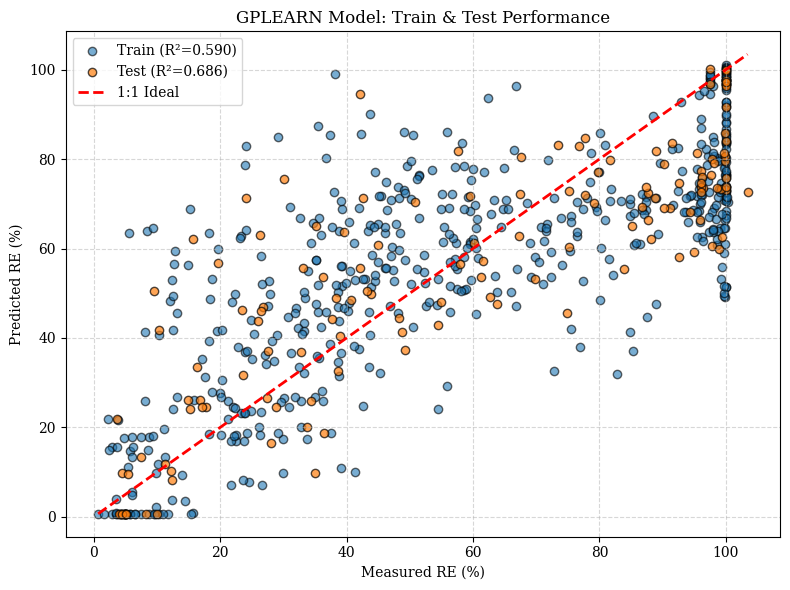

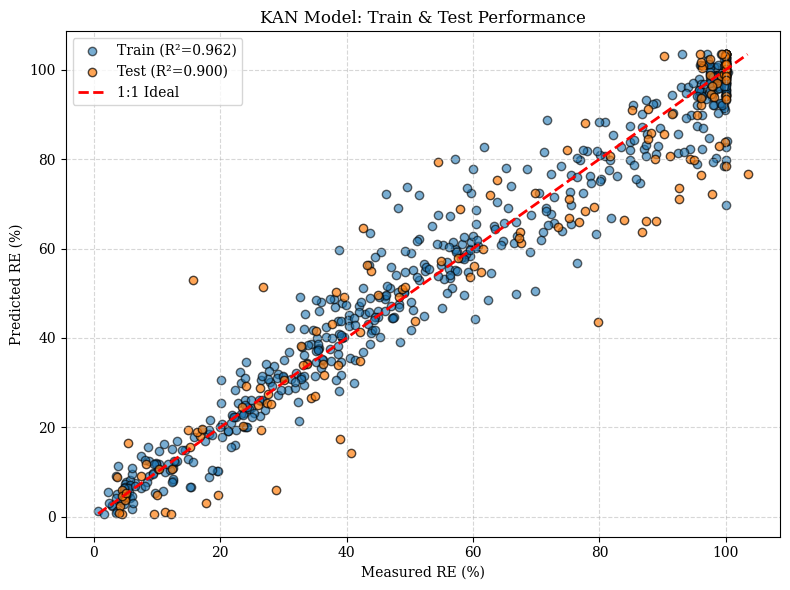

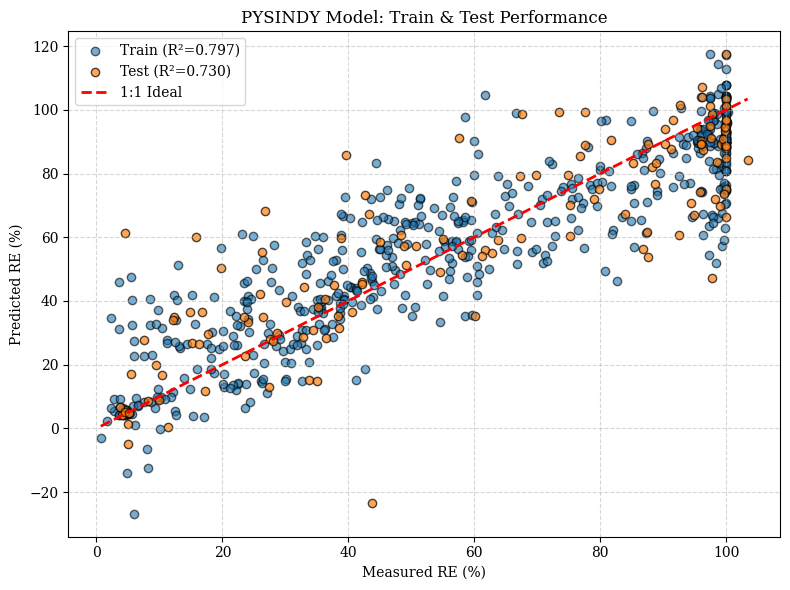

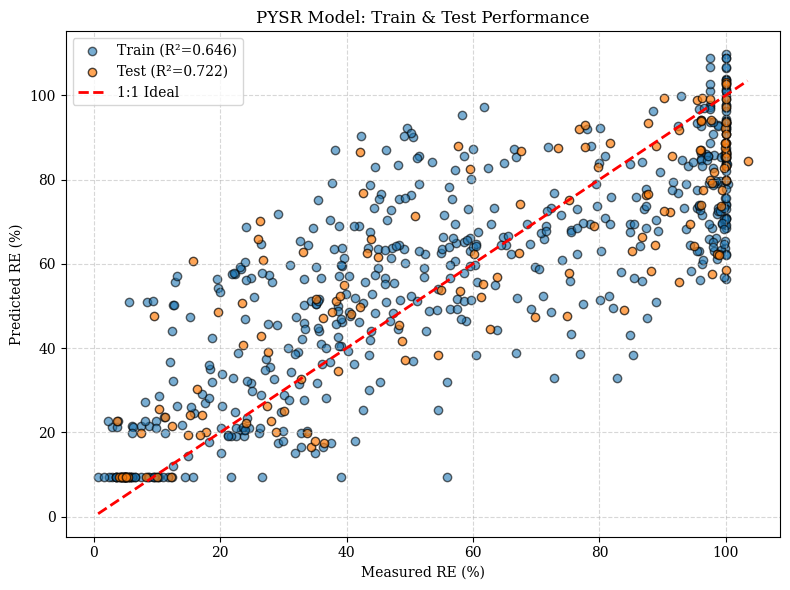

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from pathlib import Path
save_path = "./outputs"
os.makedirs(save_path, exist_ok=True)
RESULTS_DIR = Path("./Res")
models = ["gplearn", "kan", "pysindy", "pysr"]

for model in models:

    # =========================
    # Load normalized predictions
    # =========================
    train_pred_norm = pd.read_csv(
        RESULTS_DIR / model / f"{model}_train.csv"
    )["0"].values.reshape(-1, 1)

    test_pred_norm = pd.read_csv(
        RESULTS_DIR / model / f"{model}_test.csv"
    )["0"].values.reshape(-1, 1)

    # =========================
    # Inverse transform
    # =========================
    y_train = scaler_out.inverse_transform(trainy).ravel()
    y_test  = scaler_out.inverse_transform(testy).ravel()

    y_train_pred = scaler_out.inverse_transform(train_pred_norm).ravel()
    y_test_pred  = scaler_out.inverse_transform(test_pred_norm).ravel()

    # =========================
    # R² scores
    # =========================
    r2_train = r2_score(y_train, y_train_pred)
    r2_test  = r2_score(y_test, y_test_pred)

    # =========================
    # Plot
    # =========================
    plt.figure(figsize=(8, 6))

    plt.scatter(
        y_train, y_train_pred,
        alpha=0.6, edgecolors='k',
        label=f'Train (R²={r2_train:.3f})'
    )

    plt.scatter(
        y_test, y_test_pred,
        alpha=0.7, edgecolors='k',
        label=f'Test (R²={r2_test:.3f})'
    )

    lims = [
        min(y_train.min(), y_test.min()),
        max(y_train.max(), y_test.max())
    ]

    plt.plot(lims, lims, 'r--', lw=2, label='1:1 Ideal')

    plt.xlabel('Measured RE (%)')
    plt.ylabel('Predicted RE (%)')
    plt.title(f'{model.upper()} Model: Train & Test Performance')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # =========================
    # Save
    # =========================
    filename = f"{model}_Train_Test_Parity.png"
    plt.savefig(os.path.join(save_path, filename), dpi=300)
    plt.show()


# Sensitivity analysis

checkpoint directory created: ./model
saving model version 0.0


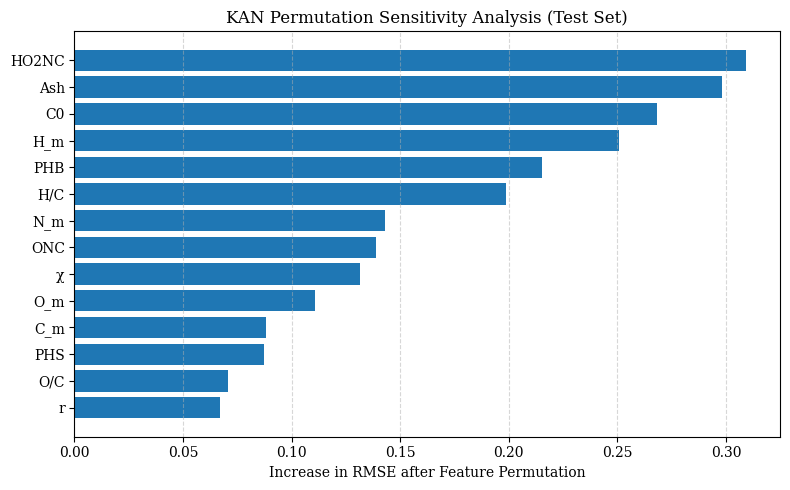

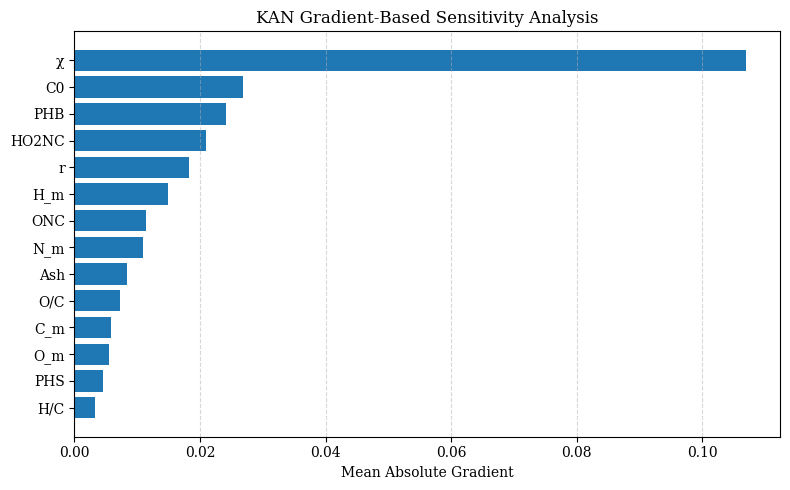

In [13]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
def load_clean(path):
    df = pd.read_excel(path).dropna(how='all')
    return df.apply(pd.to_numeric, errors='coerce').dropna()

trainx_df = load_clean('./TTV/trainx.xlsx')
trainy_df = load_clean('./TTV/trainy.xlsx')
testx_df  = load_clean('./TTV/testx.xlsx')
testy_df  = load_clean('./TTV/testy.xlsx')

feature_names = testx_df.columns.tolist()

# --- Scalers (same as training)
scaler_x = StandardScaler()
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_s = scaler_x.fit_transform(trainx_df.values)
y_train_s = scaler_y.fit_transform(trainy_df.values.reshape(-1, 1))

X_test_s  = scaler_x.transform(testx_df.values)
y_test_s  = scaler_y.transform(testy_df.values.reshape(-1, 1))

X_test = torch.tensor(X_test_s, dtype=torch.float32)
y_test = torch.tensor(y_test_s, dtype=torch.float32)


from kan import KAN  # make sure this matches your environment

model_path = './Res/kan/Winning_KAN_R2_90.pth'
state = torch.load(model_path, map_location='cpu')

hidden_width = state['node_bias_0'].shape[0]

d = X_train_s.shape[1]

model = KAN(
    width=[d, hidden_width, 1],
    grid=20,
    k=3,
    seed=40
)

model.load_state_dict(state)
model.eval()


with torch.no_grad():
    y_pred_base = model(X_test).numpy().ravel()

rmse_base = np.sqrt(mean_squared_error(y_test.numpy().ravel(), y_pred_base))


n_repeats = 10
sensitivities = []

X_perm = X_test.clone()

for i, feat in enumerate(feature_names):

    rmse_perm_all = []

    for _ in range(n_repeats):
        idx = torch.randperm(X_perm.shape[0])
        X_perm[:, i] = X_test[idx, i]

        with torch.no_grad():
            y_perm_pred = model(X_perm).numpy().ravel()

        rmse_perm = np.sqrt(
            mean_squared_error(y_test.numpy().ravel(), y_perm_pred)
        )
        rmse_perm_all.append(rmse_perm)

        # restore feature
        X_perm[:, i] = X_test[:, i]

    sensitivities.append(np.mean(rmse_perm_all) - rmse_base)


perm_sens_df = pd.DataFrame({
    "Feature": feature_names,
    "ΔRMSE (Permutation)": sensitivities
}).sort_values("ΔRMSE (Permutation)", ascending=False)

perm_sens_df


os.makedirs("./outputs", exist_ok=True)

plt.figure(figsize=(8, 5))
plt.barh(
    perm_sens_df["Feature"],
    perm_sens_df["ΔRMSE (Permutation)"]
)
plt.xlabel("Increase in RMSE after Feature Permutation")
plt.title("KAN Permutation Sensitivity Analysis (Test Set)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig("./outputs/KAN_Permutation_Sensitivity.png", dpi=300)
plt.show()


X_grad = X_test.clone().requires_grad_(True)

y_pred = model(X_grad)
y_pred.mean().backward()

grad_sensitivity = X_grad.grad.abs().mean(dim=0).detach().numpy()


grad_sens_df = pd.DataFrame({
    "Feature": feature_names,
    "Mean |∂y/∂x|": grad_sensitivity
}).sort_values("Mean |∂y/∂x|", ascending=False)

grad_sens_df


plt.figure(figsize=(8, 5))
plt.barh(
    grad_sens_df["Feature"],
    grad_sens_df["Mean |∂y/∂x|"]
)
plt.xlabel("Mean Absolute Gradient")
plt.title("KAN Gradient-Based Sensitivity Analysis")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig("./outputs/KAN_Gradient_Sensitivity.png", dpi=300)
plt.show()

